In [2]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab
from dataclasses import dataclass

import os
import json

# from uncertainties import unumpy as unp
# from uncertainties import ufloat, umath

from options import *
from constants import *

# nom_vals = unp.nominal_values
# std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
@dataclass
class Spec:
    freq: np.ndarray
    data: np.ndarray
    params: dict
    cleaned_data: np.ndarray | None = None
    vel: np.ndarray | None = None
    possible_relative_velocities: np.ndarray | None = None
    possible_radii: np.ndarray | None = None

In [4]:
def load(dataset: str) -> Spec:
    with open(dataset.replace("raw.npy", "params.json"), "r") as file:
        params = json.load(file)

    data = np.load(dataset, allow_pickle=False)

    # Newer npy
    if len(data.shape) > 1:
        frequencies, spectrum = data
    # Older, less advanced
    else:
        spectrum = data
        frequencies = np.load('../data/reference_frequencies.npy')
    
    spec = Spec(frequencies, spectrum, params)

    return spec

In [5]:
noise = load("../data/bc_test3_2025_02_28_13_31_31_raw.npy")
l30 = load("../data/vega1/h_30_2025_03_07_09_31_26_raw.npy")

In [6]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [7]:
def normalise_data(signal: np.ndarray, noise: np.ndarray) -> np.ndarray:
    return signal / noise

In [8]:
def clean_up(signal: np.ndarray, w: int = 10) -> np.ndarray:
    cleaned = sc.ndimage.uniform_filter1d(signal, size=w, mode='nearest')
    return cleaned

In [9]:
def calculate_relative_speed(measured_frequency: float) -> float:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency

## Example de cleanup signal

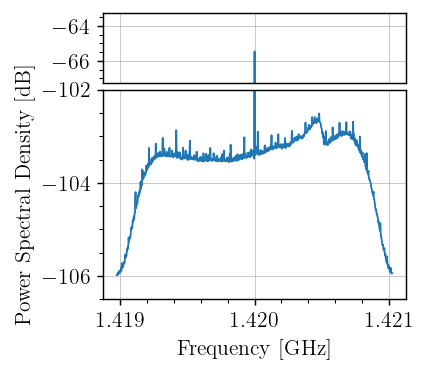

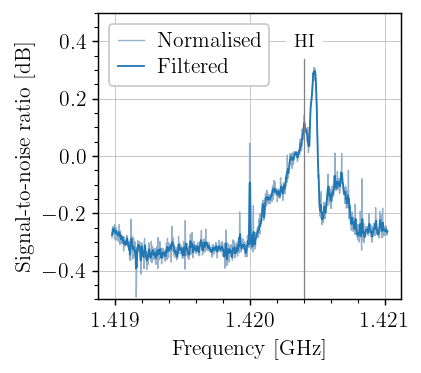

In [10]:
with mpl.rc_context():
    mpl.rcParams['savefig.bbox'] = 'standard'
    mpl.rcParams["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM)
    mpl.rcParams["figure.subplot.left"]   = 0.25
    mpl.rcParams['figure.subplot.right']  = 0.99
    mpl.rcParams['figure.subplot.top']    = 0.97
    mpl.rcParams['figure.subplot.bottom'] = 0.17
    
    vertical_lw = 0.85
    
    # ==== Unprocessed signal ====
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1,3])
    fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

    ax1.plot(l30.freq / 1e9, to_dB(l30.data))
    ax2.plot(l30.freq / 1e9, to_dB(l30.data))

    ax1.set_ylim(-67.25, -63.25)
    # ax1.set_ylim(-102, -40)
    ax2.set_ylim(-106.5,-102)
    # ax1.set_xticks([])
    ax1.tick_params(axis='x', which='both',
                bottom=False)

    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Power Spectral Density [dB]")
    plt.savefig("../figures/raw_signal.pdf")
    plt.show()

    # ==== Processed signal (noise removal + moving average)
    plt.figure()
    normalised_signal = normalise_data(l30.data, noise.data)
    cleaned_signal = clean_up(normalised_signal, w=5)
    
    plt.plot(l30.freq / 1e9, to_dB(normalised_signal), c='#93afca', lw=0.75,
             label="Normalised")
    plt.plot(l30.freq / 1e9, to_dB(cleaned_signal), c="C0",
             label="Filtered")
    # hydrogen_peak_idx = sc.signal.find_peaks(cleaned_signal, width=20)[0][2]
    # plt.axvline(frequencies[hydrogen_peak_idx], lw=vertical_lw, ls='-', c='k',
    #             label="Shifted peak")
    # plt.axvline(H21 / 1e9, lw=vertical_lw, ls="--")
    plt.axvline(H21 / 1e9, lw=0.7, c='gray', ls="-", ymax=0.86)
    plt.annotate("HI", (H21 / 1e9, 0.3), (H21 / 1e9, 0.38),
                 horizontalalignment='center', size='small', backgroundcolor='white'
                )
    
    plt.ylim(-0.5,0.5)
    
    # Fun with plots
    # plt.grid(False)
    # plt.gca().spines[['right', 'top', 'left']].set_visible(False)
    # # plt.gca().spines[['bottom', 'left']].set_position(('outward', 5))
    # plt.legend(title="Signal-to-noise", loc="upper left", bbox_to_anchor=(0, 0.85), frameon=False, handlelength=0.5)
    # plt.yticks([], [])
    # plt.ylabel("Signal-to-noise")

    plt.legend(loc="upper left")
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Signal-to-noise ratio [dB]")
    plt.savefig("../figures/clean_signal.pdf")
    plt.show()